In [101]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [102]:
image = cv2.imread('imgs/lena.png', 0).astype(np.float32)
image.shape

(512, 512)

In [103]:
def apply_convolution(image, kernel):
    return apply_correlation(image, kernel[::-1, ::-1])

def apply_correlation(image, kernel):
    (h, w) = image.shape
    (kh, kw) = kernel.shape

    pad_h = kh // 2
    pad_w = kw // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0).astype(np.float32)
    convolved_image = np.zeros_like(image).astype(np.float32)
    
    for i in range(h):
        for j in range(w):
            region = padded_image[i:i + kh, j:j + kw]
            convolved_value = np.sum(region * kernel)
            convolved_image[i, j] = convolved_value

    convolved_image = np.clip(convolved_image, 0.0, 255.0)
    return convolved_image

def gauss_kernel(size, sigma):
    kernel = np.zeros((size, size)).astype(np.float32)
    center = size // 2
    sum_val = 0 

    for i in range(size):
        for j in range(size):
            x = i - center
            y = j - center
            kernel[i, j] = (1 / (2 * np.pi * sigma ** 2)) * np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
            sum_val += kernel[i, j]

    kernel /= sum_val
    return kernel

In [104]:
def compute_gradient(im):
    sobel_filter_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]]).astype(np.float32)
    sobel_filter_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]).astype(np.float32)
    gradient_x = apply_convolution(im, sobel_filter_x)
    gradient_y = apply_convolution(im, sobel_filter_y)

    magnitude = np.sqrt(np.square(gradient_x) + np.square(gradient_y))
    magnitude *= 255.0 / magnitude.max()
    direction = np.arctan2(gradient_y, gradient_x)
    direction *= 180.0 / np.pi
    return magnitude, direction

In [105]:
def nms(magnitude, direction):
    height, width = magnitude.shape
    res = np.zeros(magnitude.shape).astype(np.float32)
    direction[direction < 0] += 180  # (-180, 180) -> (0, 180)

    for y in range(1, height - 1):
        for x in range(1, width - 1):
            current_direction = direction[y, x]
            current_magnitude = magnitude[y, x]
            if (0 <= current_direction < 22.5) or (157.5 <= current_direction <= 180):
                p = magnitude[y, x - 1]
                r = magnitude[y, x + 1]

            elif 22.5 <= current_direction < 67.5:
                p = magnitude[y + 1, x + 1]
                r = magnitude[y - 1, x - 1]

            elif 67.5 <= current_direction < 112.5:
                p = magnitude[y - 1, x]
                r = magnitude[y + 1, x]

            else:
                p = magnitude[y - 1, x + 1]
                r = magnitude[y + 1, x - 1]

            if current_magnitude >= p and current_magnitude >= r:
                res[y, x] = current_magnitude

    return res


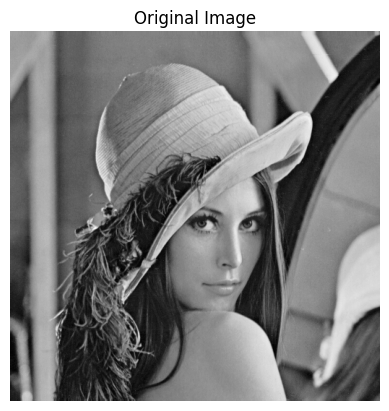

In [106]:
plt.imshow(image.astype(np.uint8), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

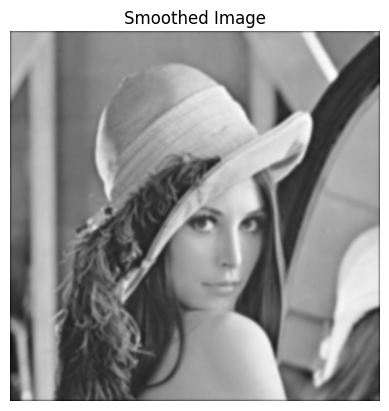

In [107]:
image_smoothed = apply_convolution(image, gauss_kernel(9, np.sqrt(3)))
plt.imshow(image_smoothed.astype(np.uint8), cmap='gray')
plt.title('Smoothed Image')
plt.axis('off')
plt.show()

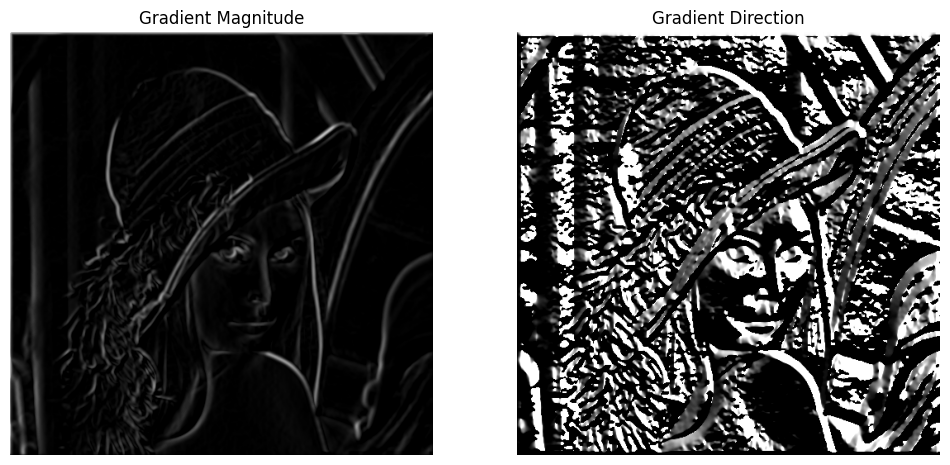

In [108]:
gradient_magnitude, gradient_direction = compute_gradient(image_smoothed)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(gradient_magnitude.astype(np.uint8), cmap='gray')
plt.title('Gradient Magnitude')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gradient_direction.astype(np.uint8), cmap='gray')
plt.title('Gradient Direction')
plt.axis('off')

plt.show()

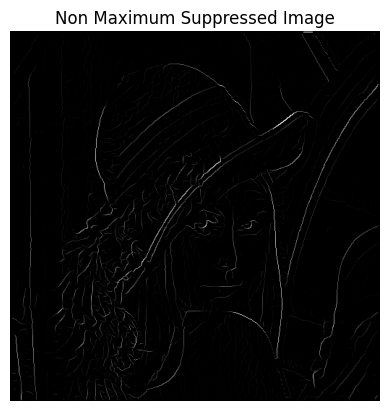

In [109]:
edge_nms = nms(gradient_magnitude, gradient_direction)
plt.imshow(edge_nms.astype(np.uint8), cmap='gray')
plt.title('Non Maximum Suppressed Image')
plt.axis('off')
plt.show()

In [110]:
def double_threshold(img, low_thresh, high_thresh):
    image = np.copy(img)
    image /= image.max()

    strong_edges = np.zeros_like(image)
    weak_edges = np.zeros_like(image)
    
    strong_edges[image >= high_thresh] = 255  
    weak_edges[(image >= low_thresh) & (image < high_thresh)] = 255
    noise = 255 - strong_edges - weak_edges
    
    return strong_edges, weak_edges, noise

def edge_linking_recursive(strong_edges, weak_edges):
    final_edges = np.copy(strong_edges) 
    rows, cols = strong_edges.shape
    
    def is_valid_pixel(r, c):
        return 0 <= r < rows and 0 <= c < cols
    
    def link_edges(r, c):
        neighbors = [(-1, -1), (-1, 0), (-1, 1), 
                     (0, -1),        (0, 1), 
                     (1, -1), (1, 0), (1, 1)]
        
        for dr, dc in neighbors:
            nr, nc = r + dr, c + dc
            if is_valid_pixel(nr, nc):
                if weak_edges[nr, nc] == 255:
                    final_edges[nr, nc] = 255
                    weak_edges[nr, nc] = 0  
                    link_edges(nr, nc)  
    
    for r in range(rows):
        for c in range(cols):
            if strong_edges[r, c] == 255: 
                link_edges(r, c)
    
    return final_edges

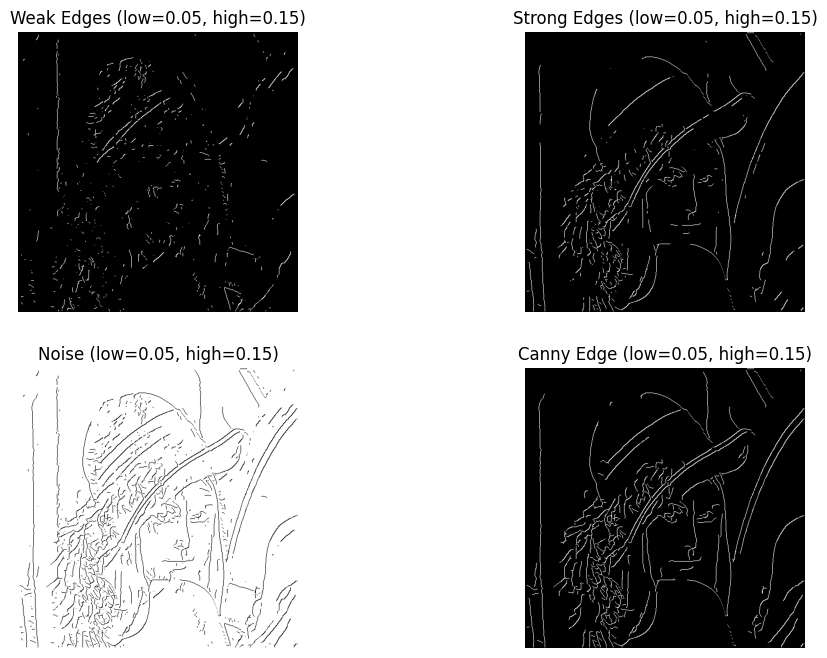

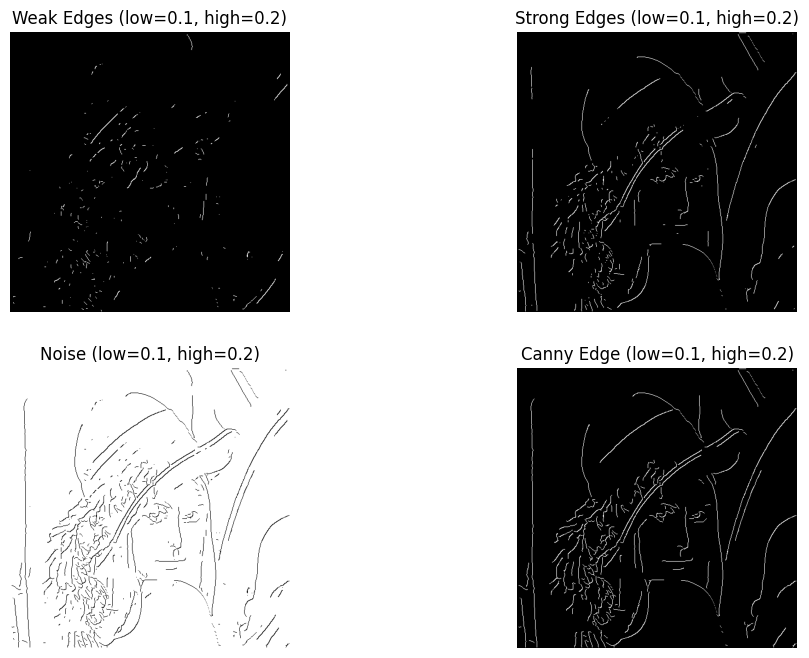

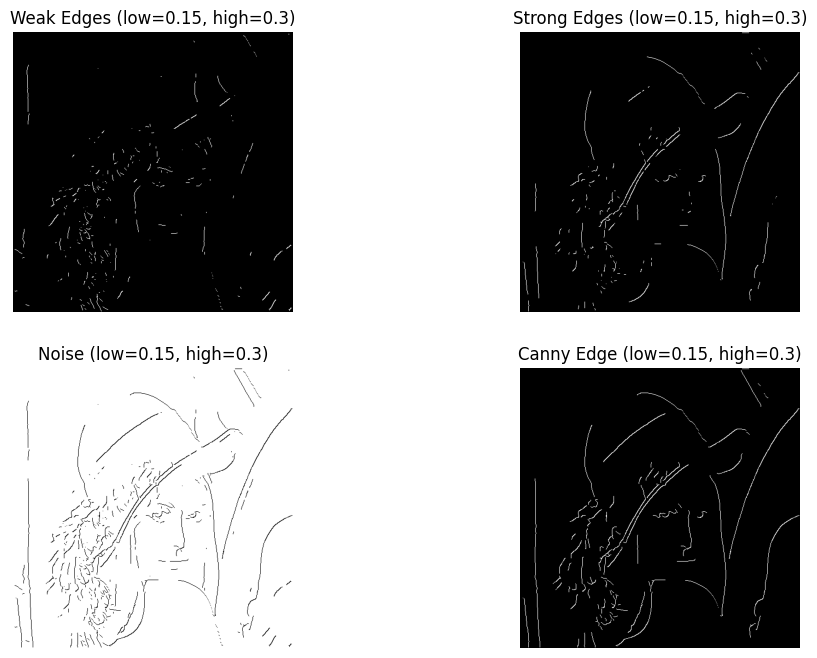

In [111]:
thresholds = [(0.05, 0.15), (0.1, 0.2), (0.15, 0.3)]

for i, (low_threshold, high_threshold) in enumerate(thresholds):
    strong_edges, weak_edges, noise = double_threshold(edge_nms, low_threshold, high_threshold)
    final_edges = edge_linking_recursive(strong_edges, weak_edges)
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.imshow(weak_edges.astype(np.uint8), cmap='gray')
    plt.title(f'Weak Edges (low={low_threshold}, high={high_threshold})')
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(strong_edges.astype(np.uint8), cmap='gray')
    plt.title(f'Strong Edges (low={low_threshold}, high={high_threshold})')
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.imshow(noise.astype(np.uint8), cmap='gray')
    plt.title(f'Noise (low={low_threshold}, high={high_threshold})')
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(final_edges.astype(np.uint8), cmap='gray')
    plt.title(f'Canny Edge (low={low_threshold}, high={high_threshold})')
    plt.axis('off')
    
    plt.show()

In [112]:
import math

def HoughTransform(edge_map):
    theta_values = np.deg2rad(np.arange(-90.0, 90.0))
    height, width = edge_map.shape
    diagonal_length = int(round(math.sqrt(width * width + height * height)))
    rho_values = np.linspace(-diagonal_length, diagonal_length, diagonal_length * 2 + 1)

    accumulator = np.zeros((len(rho_values), len(theta_values)), dtype=float)
    y_coordinates, x_coordinates = np.nonzero(edge_map)

    for edge_idx in range(len(x_coordinates)):
        x = x_coordinates[edge_idx]
        y = y_coordinates[edge_idx]
        for theta_idx in range(len(theta_values)):
            theta = theta_values[theta_idx]
            rho = int(round(x * np.cos(theta) + y * np.sin(theta)))
            accumulator[rho + diagonal_length, theta_idx] += 1

    return accumulator, theta_values, rho_values

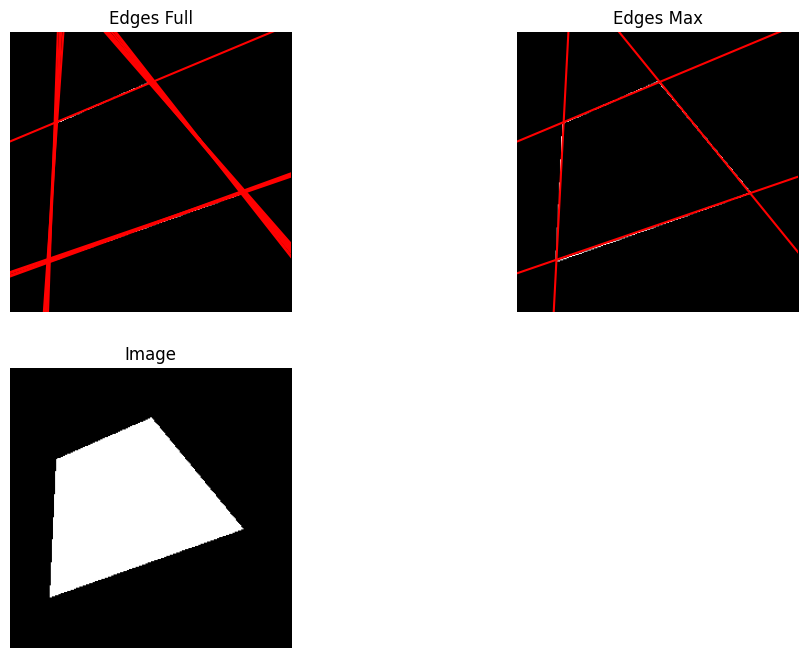

In [113]:
im = cv2.cvtColor(cv2.imread('imgs/shape.bmp'), cv2.COLOR_BGR2GRAY)
edge_map = cv2.Canny(im, 70, 150).astype(np.float32)
accumulator, theta_values, rho_values = HoughTransform(edge_map)

def nms_accumulator(accumulator):
    nms_acc = np.zeros_like(accumulator)
    size = 7

    for i in range(size // 2, accumulator.shape[0] - size // 2):
        for j in range(size // 2, accumulator.shape[1] - size // 2):
            local_region = accumulator[i - size // 2:i + size // 2 + 1, j - size // 2:j + size // 2 + 1]
            local_max = nms_acc[i - size // 2:i + size // 2 + 1, j - size // 2:j + size // 2 + 1]
            if accumulator[i, j] == np.max(local_region) and accumulator[i, j] > np.max(local_max):
                nms_acc[i, j] = accumulator[i, j]

    return nms_acc

plt.figure(figsize=(12, 8))

tresh = 45

lines = np.argwhere(accumulator > tresh)

plt.subplot(2, 2, 1)
height, width = im.shape
for line in lines:
    rho = rho_values[line[0]]
    theta = theta_values[line[1]]
    if np.sin(theta) == 0: 
        continue
    slope = -np.cos(theta)/np.sin(theta)
    intercept = rho/np.sin(theta)
    x1, x2 = 0, width
    y1 = int(slope*x1 + intercept)
    y2 = int(slope*x2 + intercept)
    plt.plot([x1, x2], [y1, y2], 'r')

plt.imshow(edge_map, cmap='gray')
plt.title('Edges Full')
plt.axis('off')

accumulator = nms_accumulator(accumulator)
lines = np.argwhere(accumulator > tresh)

plt.subplot(2, 2, 2)
height, width = im.shape
for line in lines:
    rho = rho_values[line[0]]
    theta = theta_values[line[1]]
    if np.sin(theta) == 0: 
        continue
    slope = -np.cos(theta)/np.sin(theta)
    intercept = rho/np.sin(theta)
    x1, x2 = 0, width
    y1 = int(slope*x1 + intercept)
    y2 = int(slope*x2 + intercept)
    plt.plot([x1, x2], [y1, y2], 'r')

plt.imshow(edge_map, cmap='gray')
plt.title('Edges Max')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(cv2.imread('imgs/shape.bmp'), cv2.COLOR_BGR2RGB)) 
plt.title('Image')
plt.axis('off')

plt.show()

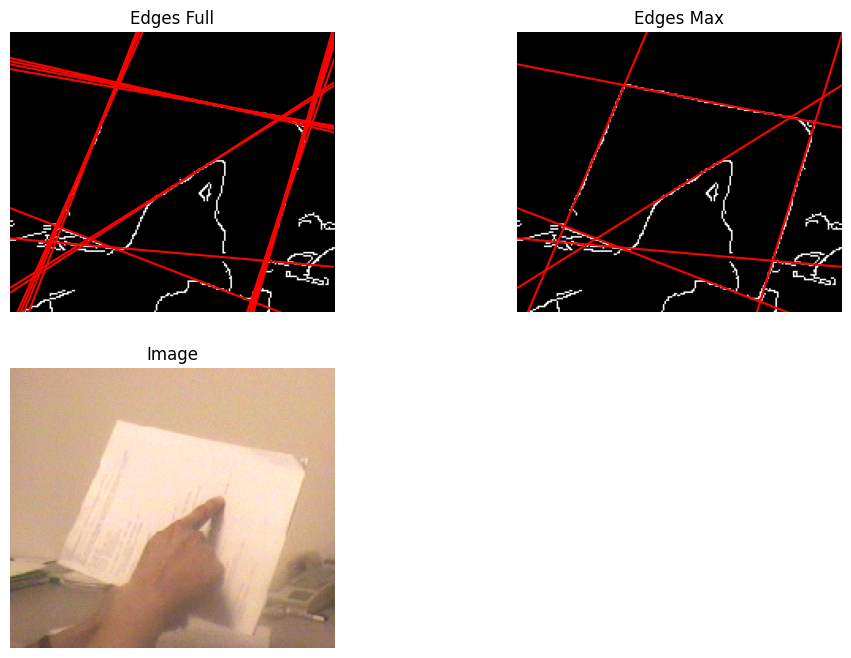

In [114]:
im = cv2.cvtColor(cv2.imread('imgs/paper.bmp'), cv2.COLOR_BGR2GRAY)
edge_map = cv2.Canny(im, 70, 150).astype(np.float32)
accumulator, theta_values, rho_values = HoughTransform(edge_map)

plt.figure(figsize=(12, 8))

lines = np.argwhere(accumulator > tresh)

plt.subplot(2, 2, 1)
height, width = im.shape
for line in lines:
    rho = rho_values[line[0]]
    theta = theta_values[line[1]]
    if np.sin(theta) == 0: 
        continue
    slope = -np.cos(theta)/np.sin(theta)
    intercept = rho/np.sin(theta)
    x1, x2 = 0, width
    y1 = int(slope*x1 + intercept)
    y2 = int(slope*x2 + intercept)
    plt.plot([x1, x2], [y1, y2], 'r')

plt.imshow(edge_map, cmap='gray')
plt.title('Edges Full')
plt.axis('off')

accumulator = nms_accumulator(accumulator)
lines = np.argwhere(accumulator > tresh)

plt.subplot(2, 2, 2)
height, width = im.shape
for line in lines:
    rho = rho_values[line[0]]
    theta = theta_values[line[1]]
    if np.sin(theta) == 0: 
        continue
    slope = -np.cos(theta)/np.sin(theta)
    intercept = rho/np.sin(theta)
    x1, x2 = 0, width
    y1 = int(slope*x1 + intercept)
    y2 = int(slope*x2 + intercept)
    plt.plot([x1, x2], [y1, y2], 'r')

plt.imshow(edge_map, cmap='gray')
plt.title('Edges Max')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(cv2.imread('imgs/paper.bmp'), cv2.COLOR_BGR2RGB)) 
plt.title('Image')
plt.axis('off')

plt.show()

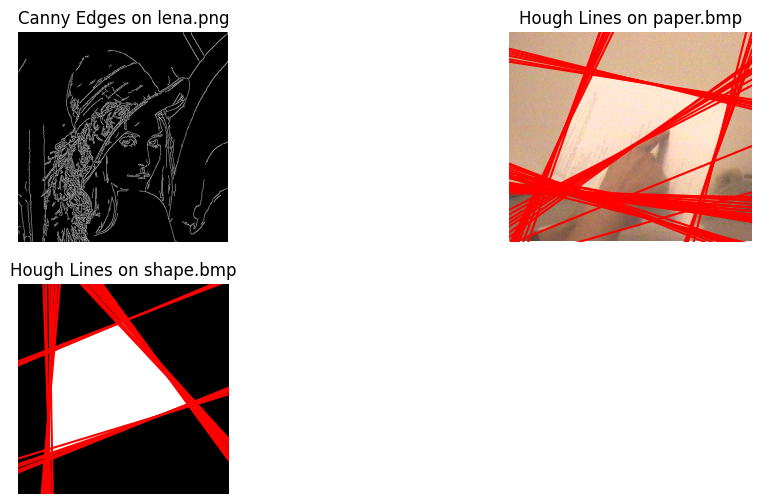

In [115]:
def plot_hough_lines(image, lines, color='r'):
    height, width = image.shape
    for line in lines:
        rho, theta = line[0]
        if np.sin(theta) == 0: 
            continue
        slope = -np.cos(theta)/np.sin(theta)
        intercept = rho/np.sin(theta)
        x1, x2 = 0, width
        y1 = int(slope*x1 + intercept)
        y2 = int(slope*x2 + intercept)
        plt.plot([x1, x2], [y1, y2], 'r')

lena_edges = cv2.Canny(image.astype(np.uint8), 70, 150).astype(np.float32)
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.imshow(lena_edges, cmap='gray')
plt.title('Canny Edges on lena.png')
plt.axis('off')


im_paper = cv2.cvtColor(cv2.imread('imgs/paper.bmp'), cv2.COLOR_BGR2GRAY)
edge_map_paper = cv2.Canny(im_paper, 70, 150).astype(np.float32)
lines_paper = cv2.HoughLines(edge_map_paper.astype(np.uint8), 1, np.pi / 180, 30)

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(cv2.imread('imgs/paper.bmp'), cv2.COLOR_BGR2RGB))
plt.gca().set_xlim([0, im_paper.shape[1]])
plt.gca().set_ylim([im_paper.shape[0], 0])
plot_hough_lines(im_paper, lines_paper)
plt.title('Hough Lines on paper.bmp')
plt.axis('off')

plt.subplot(2, 2, 3)

im_shape = cv2.cvtColor(cv2.imread('imgs/shape.bmp'), cv2.COLOR_BGR2GRAY)
edge_map_shape = cv2.Canny(im_shape, 70, 150).astype(np.float32)
lines_shape = cv2.HoughLines(edge_map_shape.astype(np.uint8), 1, np.pi / 180, 20)

plt.imshow(cv2.cvtColor(cv2.imread('imgs/shape.bmp'), cv2.COLOR_BGR2RGB))
plt.gca().set_xlim([0, im_shape.shape[1]])
plt.gca().set_ylim([im_shape.shape[0], 0])
plot_hough_lines(im_shape, lines_shape)
plt.title('Hough Lines on shape.bmp')
plt.axis('off')

plt.show()